# Machine Learning Engineer Nanodegree
## Capstone Project
## Predicting Ames Houses on the Entire Feature Set

The ultimate goal of this project is to predict how much a house should be solved in Ames, IA.
The problem is a standing [Kaggle Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The dataset contains a list of information for all houses sold in Ames, Iowa from 2006 through 2010. It contains **2930** observations and a large number of explanatory
variables (**23 nominal, 23 ordinal, 14 discrete, and 20 continuous**). Dean De Cook compiled and published this dataset in 2011 and can be found here [here](http://www.amstat.org/publications/jse/v19n3/decock.pdf). 

With the entry Id removed, the dataset is described by 304 features, after transformation of the categoricals to dummy variables.

## I . Import necessary modules.

In [125]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.5) 
sns.set_style("white")

# Pretty display for notebooks
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as grd
import matplotlib.ticker as tkr
import matplotlib.font_manager as font_manager

from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams

#define plotter
minorLocatorx   = AutoMinorLocator(10)
minorLocatory   = AutoMinorLocator(4)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.linewidth'] = 4
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman') 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
 

## II. Load the dataset and drop the unnecessary sample ID.

In [126]:
# Load the Ames housing dataset. This will have to be split for evaluation!
data = pd.read_csv('train.csv')
data['Age'] = data.YrSold - data.YearBuilt
data['RemodAge'] = data.YrSold - data.YearRemodAdd
data = data.drop(['Id', 'YrSold', 'YearBuilt', 'YearRemodAdd'], axis=1)
data['MSSubClass'] = data['MSSubClass'].astype(int).astype('str')

# Success
print "Ames housing dataset has {} data points with {} variables each.".format(*data.shape)
print data.head(3)

Ames housing dataset has 1460 data points with 79 variables each.
  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour  \
0         60       RL         65.0     8450   Pave   NaN      Reg         Lvl   
1         20       RL         80.0     9600   Pave   NaN      Reg         Lvl   
2         60       RL         68.0    11250   Pave   NaN      IR1         Lvl   

  Utilities LotConfig   ...    PoolQC Fence MiscFeature MiscVal MoSold  \
0    AllPub    Inside   ...       NaN   NaN         NaN       0      2   
1    AllPub       FR2   ...       NaN   NaN         NaN       0      5   
2    AllPub    Inside   ...       NaN   NaN         NaN       0      9   

  SaleType  SaleCondition  SalePrice Age RemodAge  
0       WD         Normal     208500   5        5  
1       WD         Normal     181500  31       31  
2       WD         Normal     223500   7        6  

[3 rows x 79 columns]


## III. Define training and preprocessing functions

In [127]:
# Define functions for creating sets and training.
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

############################################## Create Train/Test Splits ##############################################
############################################## Create Train/Test Splits ##############################################

def create_sets(X, y):
    # Split into training and testing components first
    from sklearn.cross_validation import train_test_split, ShuffleSplit
    
    # Set the number of training points
    num_train = int(round(0.80*len(X)))
    
    # Set the number of testing points
    num_test = X.shape[0] - num_train
    
    # Shuffle and split the dataset into the number of training and testing points above
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = num_train, random_state=123458)
    
    # Show the results of the split
    print "Training set has {} samples.".format(X_train.shape[0])
    print "Testing set has {} samples.".format(X_test.shape[0])
    return X_train, X_test, y_train, y_test

##############################################   Model   Fitting   ##############################################
##############################################   Model   Fitting   ##############################################

# Using GridSearch CV, we fine tune the model.

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.grid_search import GridSearchCV


def fit_model(X, y, n_estimators = 1000, min_samples_leaf = 1, min_samples_split =2):
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20)
    regressor = GradientBoostingRegressor(n_estimators=n_estimators,min_samples_leaf = 1, 
                                          min_samples_split =2,random_state=102345, loss = 'lad')

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'learning_rate': [0.01, 0.02, 0.05, 0.1], # 'n_estimators': [100, 500, 1000],
              'max_depth': [2, 3, 4, 6], 'min_samples_leaf':  [2,3,5,9,17]}
    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)
    # Create the grid search object
    grid = GridSearchCV(regressor, params, cv=cv_sets, scoring = scoring_fnc)#, verbose=10)
    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    # Print the optimal model after fitting the data
    print 'The cross-validation scores = {:.2f}'.format(grid.best_score_)
    print grid.best_estimator_
    return grid

In [128]:
#Make dummies for categorical features.
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    conv_col =  ['BsmtQual', 'BsmtCond', 'ExterQual', 'ExterCond', 'HeatingQC', 
                 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        if col in conv_col:
            if col_data.dtype == object:
                col_data = col_data.replace(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA' ], [9, 7, 5, 3, 2, 0 ]) 
        if col == 'MSSubClass':
            col_data.dtype == object
        #if col == 'Functional':
        #    col_data.dtype == int
        #    col_data = col_data.replace(['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'],
        #                                 [10, 9, 8, 6, 4, 3, 1, 0])
        #if col == 'LandSlope':
        #    col_data = col_data.replace(['Gtl', 'Mod', 'Sev'], [1, 5, 10])
        #if col == 'GarageFinish':
        #    col_data = col_data.replace(['Fin', 'RFn', 'Unf', 'NA'] , [10, 5, 3,0])
        ## If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['Y', 'N'], [1, 0])
        if col == 'PavedDrive':
            col_data = col_data.replace(['Y', 'P', 'N'], [1.0, 0.5, 0])
        #if col ==  'Heating':
        #    col_data = col_data.replace(['GasA', 'GasW', 'OthW', 'Wall', 'Grav',  'Floor'], [10, 8, 7, 5, 4, 3])
        #if col ==  'MasVnrType':
        #    col_data = col_data.replace(['Stone', 'BrkFace', 'None', 'BrkCmn'], [5,4,3,1])                                
        if col == 'Street':
            col_data = col_data.replace(['Grvl', 'Pave'], [0, 1])
        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'GarageCond' => 'GarageCond_Ex', etc.
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

In [129]:
def remove_nans(df):
    nan_df = df[pd.isnull(df).any(axis=1)]
    for col in nan_df.columns:
        tmp = nan_df[col][pd.isnull(nan_df[col])]
        if len(tmp) >= 1:
            #print "These features have NULLs to signify the absence of such a feature:"
            print col, len(tmp)
            df[col] = df[col].fillna(0.)
    print np.shape(df)
    return df

# <center/> IV. Process and Train data.

 ## <center> 4.1 WITH REPEAT OUTLIERS

## 4.1.1 Preprocessing ...

In [130]:
data = remove_nans(data)
y_all =  data['SalePrice'] #in the log
X_all =  data.drop(['SalePrice'], axis=1)

LotFrontage 259
Alley 1369
MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406
(1460, 79)


In [131]:
X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(sorted(X_all.columns)))
print np.shape(X_all)

Processed feature columns (273 total features):
['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Age', 'Alley_0.0', 'Alley_Grvl', 'Alley_Pave', 'BedroomAbvGr', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'BsmtCond', 'BsmtExposure_0.0', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1_0.0', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_0.0', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN',

> ## Feature size ballooned to 268 (from 304).

## 4.1.2 Investigate learning curves

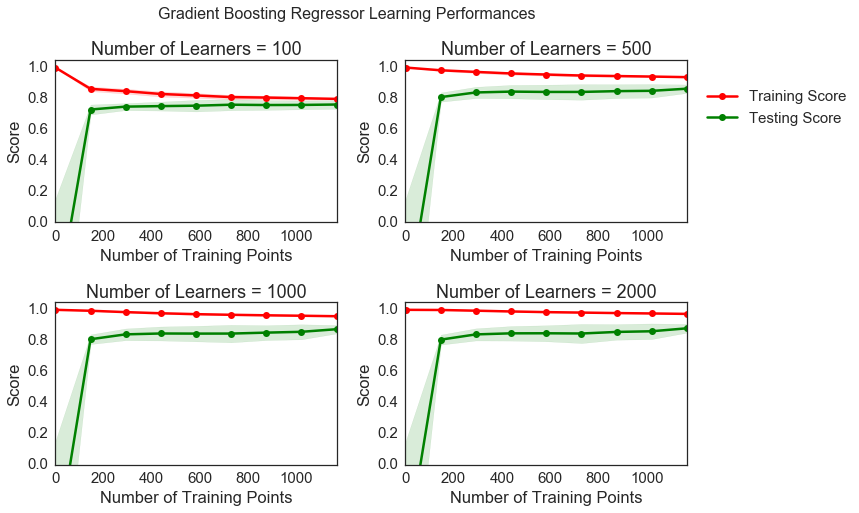

In [8]:
import visuals as vs
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("white")
vs.ModelLearning(X_all, y_all)


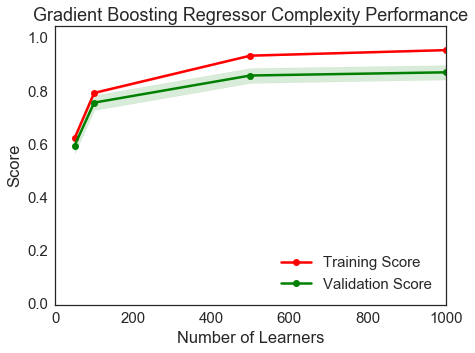

In [9]:
vs.ModelComplexity(X_all, y_all)

> ### We likely need 1000$^{ish}$ estimators. As before, we use the usual 80-20 split.

## 4.1.3 Begin training the full sample size.

In [12]:
#X_train, X_test, y_train, y_test = create_sets(X_all, y_all)
#reg = fit_model(X_train, y_train, n_estimators=1000, min_samples_leaf = 1, min_samples_split = 10)
#pred = reg.predict(X_test)
#    
#print 'The R$^2$ = {:.2f}'.format(r2_score(pred, y_test))
#print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred, y_test))

In [133]:
## This is the result of the grid search by fit_model:
X_train, X_test, y_train, y_test = create_sets(X_all, y_all)
reg2 = GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01,
             loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=4, min_samples_split=3,
             min_weight_fraction_leaf=0.0, n_estimators=1500,
             presort='auto', random_state=102345, subsample=1.0, verbose=0,
             warm_start=False)
reg2.fit(X_train, y_train)

Training set has 1168 samples.
Testing set has 292 samples.


GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01,
             loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=4, min_samples_split=3,
             min_weight_fraction_leaf=0.0, n_estimators=1500,
             presort='auto', random_state=102345, subsample=1.0, verbose=0,
             warm_start=False)

In [134]:
pred2 = reg2.predict(X_test)
    
print 'The R$^2$ = {:.2f}'.format(r2_score(pred2, y_test))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred2, y_test))

The R$^2$ = 0.87
The  RMSE = 5.39e+08.


## 4.1.4 Visualize results.

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 7 Text yticklabel objects>)

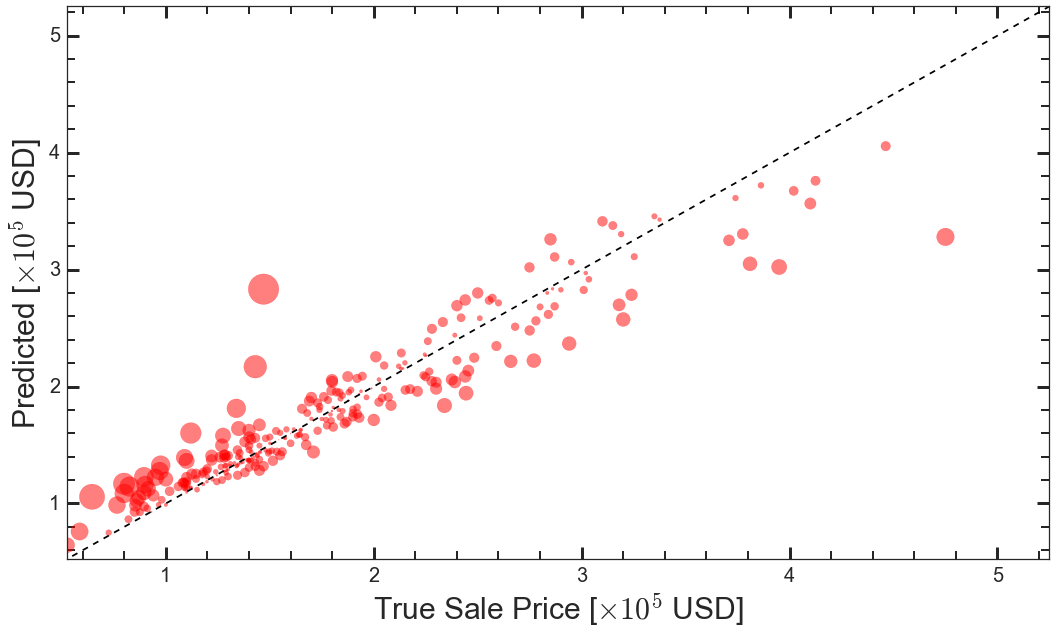

In [135]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
plt.scatter(y_test/1e5, pred2/1e5, alpha = 0.5, s = 1000*np.abs(y_test-pred2)/y_test, color = 'red')
plt.xlabel(r"True Sale Price [$\times 10^{5} $ USD]", fontsize = 30);
plt.ylabel(r"Predicted [$\times 10^{5} $ USD]", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.plot(np.arange(0,10, 1), np.arange(0,10, 1), 'k--')
plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.xlim(min([min(y_test), min(pred2)])/1e5, max([max(y_test)-0.5, max(pred2)])/1e5+0.5)
plt.ylim(min([min(y_test), min(pred2)])/1e5, max([max(y_test)-0.5, max(pred2)])/1e5+0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig("FinalModel_linear_all.pdf")


The mean is -2.67 and stdev of 13.27
The Kaggle log-RMSE is now 0.12094


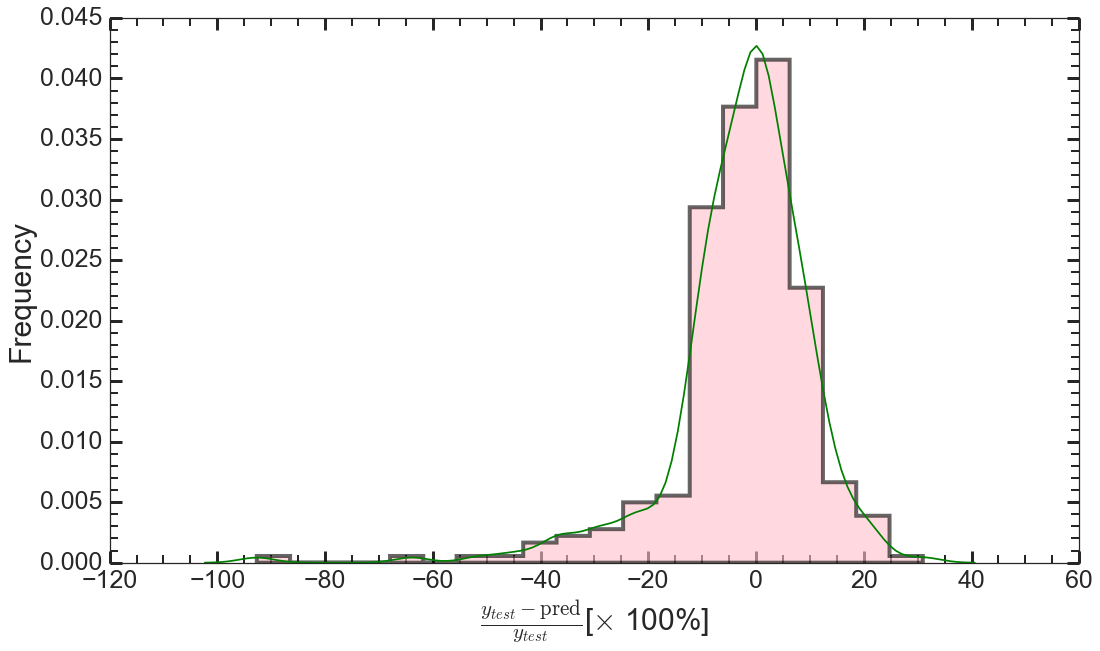

In [136]:
diff = (y_test - pred2)/y_test*100.
sns.distplot(diff, bins=20, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
                                                    "alpha": 0.60, "color": "pink"});
plt.xlabel(r"$\frac{y_{test} - \mathrm{pred} }{y_{test}}$" + r"[$ \times $ 100%]", fontsize = 30);
plt.ylabel(r"Frequency", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
print "The mean is {:.2f} and stdev of {:.2f}".format(np.mean(diff), np.std(diff))
#plt.savefig('FinalDiffDist_linear_all.pdf')
print "The Kaggle log-RMSE is now {:.5f}".format(np.sqrt(np.sum((np.log(y_test +1) - np.log(pred2+1))**2)/len(y_test)))

(52500, 475000)

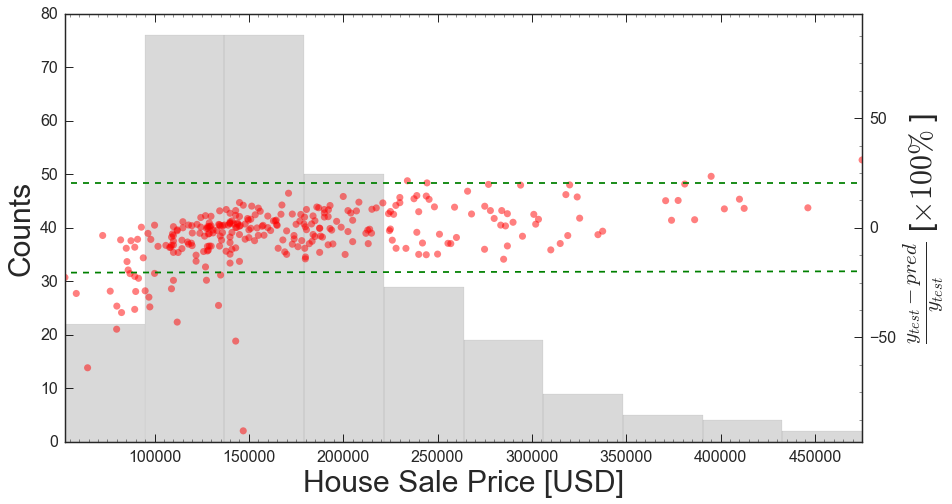

In [137]:
#SECONDARY AXIS WITH COLOR BAR

from scipy import stats

fig = plt.figure()#, figsize=(6,6))
gs = grd.GridSpec(2, 1, height_ratios=[1,15], width_ratios=[20,1], wspace=0.1)

#Primary plot
ax1 = plt.subplot(gs[1])
ax1.hist(y_test, color = ["black"], alpha=0.15)

plt.xlabel(r'House Sale Price [USD]', size=30)
plt.ylabel('Counts', size = 30)


#Secondary AXIS
ax2 = ax1.twinx()
ax2.xaxis.set_minor_locator(minorLocatorx)
ax2.yaxis.set_minor_locator(minorLocatory)

ax2.scatter(y_test, diff,  edgecolor= 'none', s=50, c='red', alpha=0.5)
ax2.set_ylabel(r"$\frac{y_{test} - pred }{y_{test}}$" + r" [$\times 100\% $ ]", fontsize = 30);

plt.plot([0, 1e8], [2*np.std(np.abs(diff)),2*np.std(np.abs(diff))], color = 'green', linestyle = '--')
plt.plot([0, 1e8], [-2*np.std(np.abs(diff)),12*np.std(np.abs(diff))], color = 'green', linestyle = '--')
plt.ylim(min(diff)-5, max(np.abs(diff))+5)
plt.xlim(min(y_test), max(y_test));
#plt.savefig('Residuals_linear_all.pdf')

In [138]:
print "The Kaggle log-RMSE ON THE TEST SET is now {:.5f}".format(np.sqrt(np.sum((np.log(y_test +1) - np.log(pred2+1))**2)/len(y_test)))

The Kaggle log-RMSE ON THE TEST SET is now 0.12094


# <center> 4.2 Removing outliers NOW!

### Using [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal. 

## 4.2.1 Define function that removes REPEAT outliers. 

Consider as outliers only for those which are continuous variables.

In [139]:
## Try to remove outliers
# For each feature in out_columns find the data points with extreme high or low values
def remove_outliers(df):
    outliers  = []
    out_columns = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 
                   'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice', '1stFlrSF', 
                   "2ndFlrSF", "ScreenPorch", "PoolArea", '3SsnPorch', "MiscVal", "EnclosedPorch",
                   'BsmtFinSF2','LowQualFinSF', "BsmtUnfSF", 'LotFrontage']
    for feature in out_columns:
        
        # Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(df[feature], 25)
        
        # Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(df[feature], 75)
        
        # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3-Q1)
        
        outliers = list(outliers + df[~((df[feature] >= Q1 - step) & \
                                                  (df[feature] <= Q3 + step))].index.tolist())
    
    # Select the indices for data points you wish to remove
    from collections import Counter
    counts = Counter(outliers)
    outliers = sorted([value for value, count in counts.items() if count > 1])
    return outliers

## 4.2.2 Start from a clean slate and then preprocess.

In [140]:
## Start from a clean slate.
data = pd.read_csv('train.csv')
data['Age'] = data.YrSold - data.YearBuilt
data['RemodAge'] = data.YrSold - data.YearRemodAdd
data = data.drop(['Id', 'YrSold', 'YearBuilt', 'YearRemodAdd'], axis=1)
data['MSSubClass'] = data['MSSubClass'].astype(int).astype('str')


# Remove NaNs
data_all = remove_nans(data)


# Dummies
data = preprocess_features(data)
print data.shape


# Remove Outliers
outliers = remove_outliers(data)
good_data = data.drop(data.index[outliers]).reset_index(drop = True)
good_data_y =  good_data['SalePrice']
good_data_X = good_data.drop(['SalePrice'], axis=1)


print "The dimensions of the data without outliers now is {}".format(np.shape(good_data_X))

LotFrontage 259
Alley 1369
MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406
(1460, 79)
(1460, 274)
The dimensions of the data without outliers now is (1237, 273)


In [141]:
test_data_out = data.iloc[outliers, :]
y_out = test_data_out['SalePrice']
X_out = test_data_out.drop('SalePrice', axis=1)
pred_out = reg2.predict(X_out)

The R$^2$ = 0.74
The  RMSE = 2.37e+09.
223


(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 <a list of 10 Text yticklabel objects>)

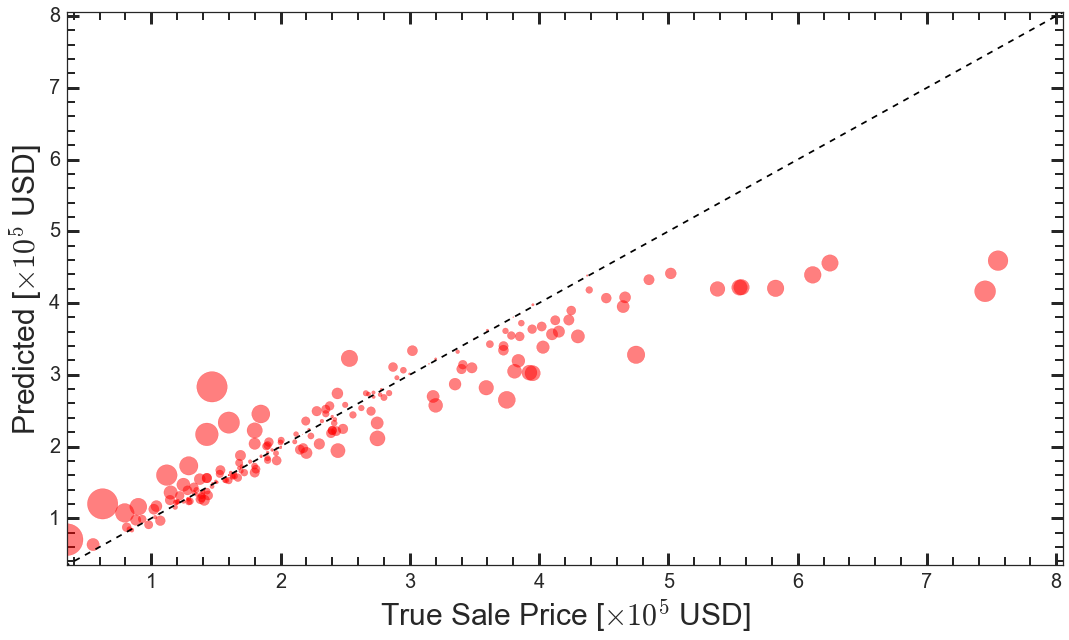

In [142]:
print 'The R$^2$ = {:.2f}'.format(r2_score(pred_out, y_out))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred_out, y_out))
print len(pred_out)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
plt.scatter(y_out/1e5, pred_out/1e5, alpha = 0.5, s = 1000*np.abs(y_out-pred_out)/y_out, color = 'red');
plt.xlabel(r"True Sale Price [$\times 10^{5} $ USD]", fontsize = 30);
plt.ylabel(r"Predicted [$\times 10^{5} $ USD]", fontsize = 30);
plt.minorticks_on();
plt.tight_layout();
plt.plot(np.arange(0,10, 1), np.arange(0,10, 1), 'k--');
plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.xlim(min([min(y_out), min(pred_out)])/1e5, max([max(y_out)-0.5, max(pred_out)])/1e5+0.5);
plt.ylim(min([min(y_out), min(pred_out)])/1e5, max([max(y_out)-0.5, max(pred_out)])/1e5+0.5);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
#plt.savefig("FinalModel_linear_all.pdf")

The mean is 0.33 and stdev of 16.55
223


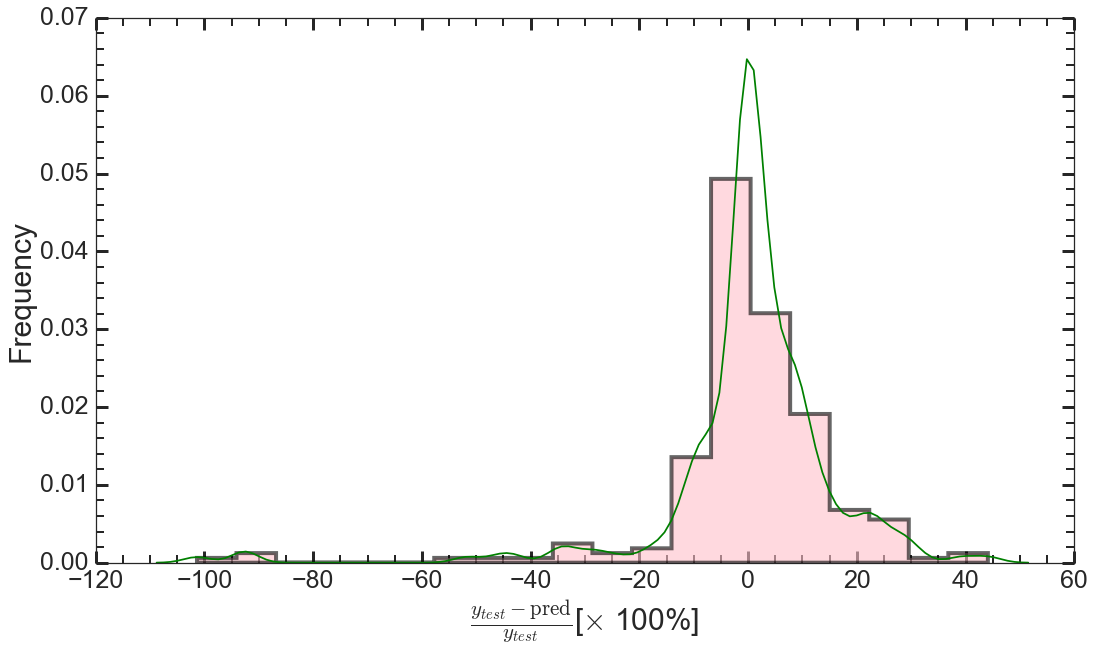

In [143]:
diff_out = (y_out - pred_out)/y_out*100.
sns.distplot(diff_out, bins=20, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
                                                    "alpha": 0.60, "color": "pink"});
plt.xlabel(r"$\frac{y_{test} - \mathrm{pred} }{y_{test}}$" + r"[$ \times $ 100%]", fontsize = 30);
plt.ylabel(r"Frequency", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
#plt.savefig('FinalDiffDist_linear_out.pdf')

print "The mean is {:.2f} and stdev of {:.2f}".format(np.mean(diff_out), np.std(diff_out))
diff_out = diff_out.reset_index(drop=True)
print len(diff_out)

## 4.2.3 Begin training without outliers

In [144]:
X_train_good, X_test_good, y_train_good, y_test_good = create_sets(good_data_X, good_data_y)

from time import time
start = time()
reg_good = fit_model(X_train_good, y_train_good, n_estimators=1000, min_samples_leaf = 1, min_samples_split = 10)
end = time()
print "Trained model in {:.2f} minutes".format((end-start)/60.)

start = time()
pred_good = reg_good.predict(X_test_good)
end = time()
print "Model made predictions in {:.4f} seconds".format((end-start))

Training set has 990 samples.
Testing set has 247 samples.
The cross-validation scores = 0.92
GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='lad',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=102345, subsample=1.0, verbose=0,
             warm_start=False)
Trained model in 74.63 minutes
Model made predictions in 0.0054 seconds


## 4.2.4 Evaluate, validate and visualize results.

There are 247 examples for testing.

In [145]:
print 'The R$^2$ = {:.2f}'.format(r2_score(pred_good, y_test_good))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred_good, y_test_good))

The R$^2$ = 0.93
The  RMSE = 2.47e+08.


(array([ 0.,  1.,  2.,  3.,  4.,  5.]), <a list of 6 Text yticklabel objects>)

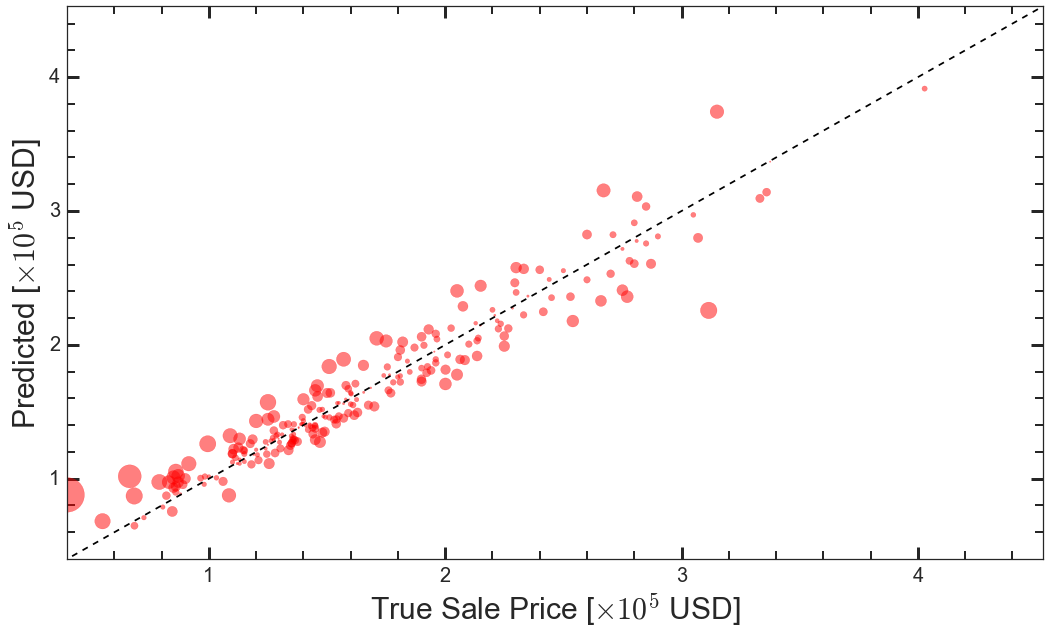

In [147]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
plt.scatter(y_test_good/1e5, pred_good/1e5, alpha = 0.5, s = 1000*np.abs(y_test_good-pred_good)/y_test_good, color = 'red')
plt.xlabel(r"True Sale Price [$\times 10^{5} $ USD]", fontsize = 30);
plt.ylabel(r"Predicted [$\times 10^{5} $ USD]", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.plot(np.arange(0,10, 1), np.arange(0,10, 1), 'k--')
plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.xlim(min([min(y_test_good), min(pred_good)])/1e5, max([max(y_test_good)-0.5, max(pred_good)])/1e5+0.5)
plt.ylim(min([min(y_test_good), min(pred_good)])/1e5, max([max(y_test_good)-0.5, max(pred_good)])/1e5+0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig("FinalModel_linear_all.pdf")

The mean is -1.74 and stdev of 12.06
The Kaggle log-RMSE is now 0.1033


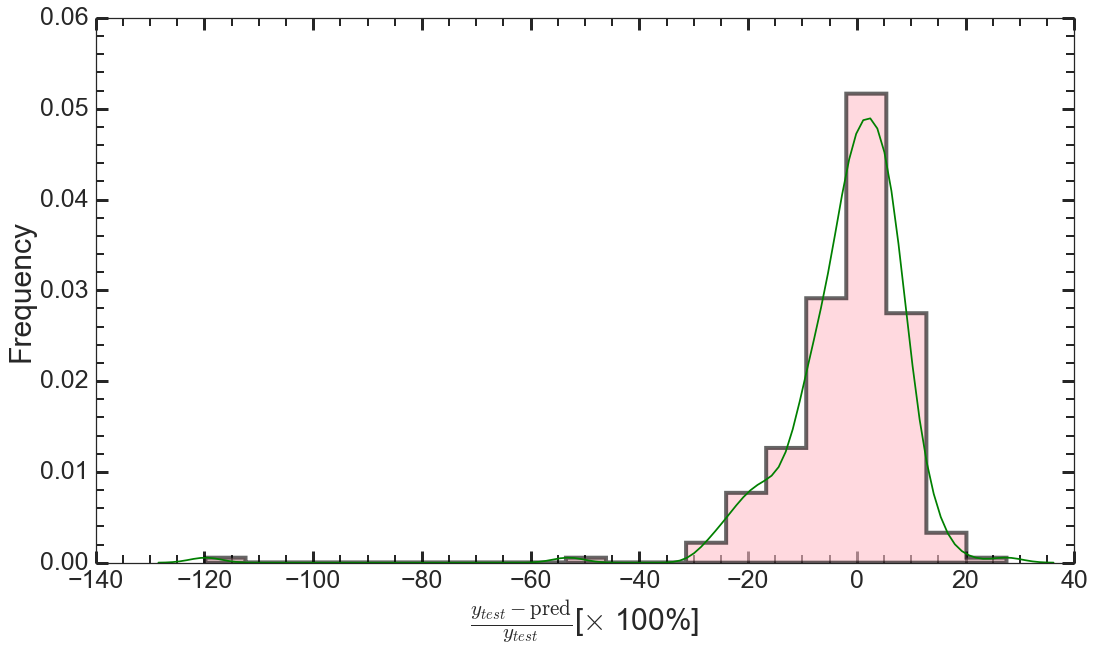

In [148]:
diff_good = (y_test_good - pred_good)/y_test_good*100.
sns.distplot(diff_good, bins=20, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
                                                    "alpha": 0.60, "color": "pink"});
plt.xlabel(r"$\frac{y_{test} - \mathrm{pred} }{y_{test}}$" + r"[$ \times $ 100%]", fontsize = 30);
plt.ylabel(r"Frequency", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
#plt.savefig('FinalDiffDist_linear_all.pdf')

print "The mean is {:.2f} and stdev of {:.2f}".format(np.mean(diff_good), np.std(diff_good))
print "The Kaggle log-RMSE is now {:.4f}".format(np.sqrt(np.sum((np.log(y_test_good +1) - 
                                                                 np.log(pred_good+1))**2)/len(y_test_good)))

## How does the model predict outliers?

In [149]:
test_data_out = data.iloc[outliers, :]
y_out = test_data_out['SalePrice']
X_out = test_data_out.drop('SalePrice', axis=1)

X_test_data_out_good = X_out.append(X_test_good, ignore_index=True)
y_test_data_out_good = y_out.append(y_test_good)

print 'The outliers and test set combined has {} examples'.format(len(X_test_data_out_good))

The outliers and test set combined has 470 examples


In [150]:
## Predict the outliers
pred_out = reg_good.predict(X_out)
print 'The R$^2$ = {:.2f}'.format(r2_score(pred_out, y_out))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred_out, y_out))

## Predict the test and outliers
pred_out_good = reg_good.predict(X_test_data_out_good)
print 'The R$^2$ = {:.2f}'.format(r2_score(pred_out_good, y_test_data_out_good))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred_out_good, y_test_data_out_good))

The R$^2$ = 0.42
The  RMSE = 4.32e+09.
The R$^2$ = 0.64
The  RMSE = 2.18e+09.


## Visualize

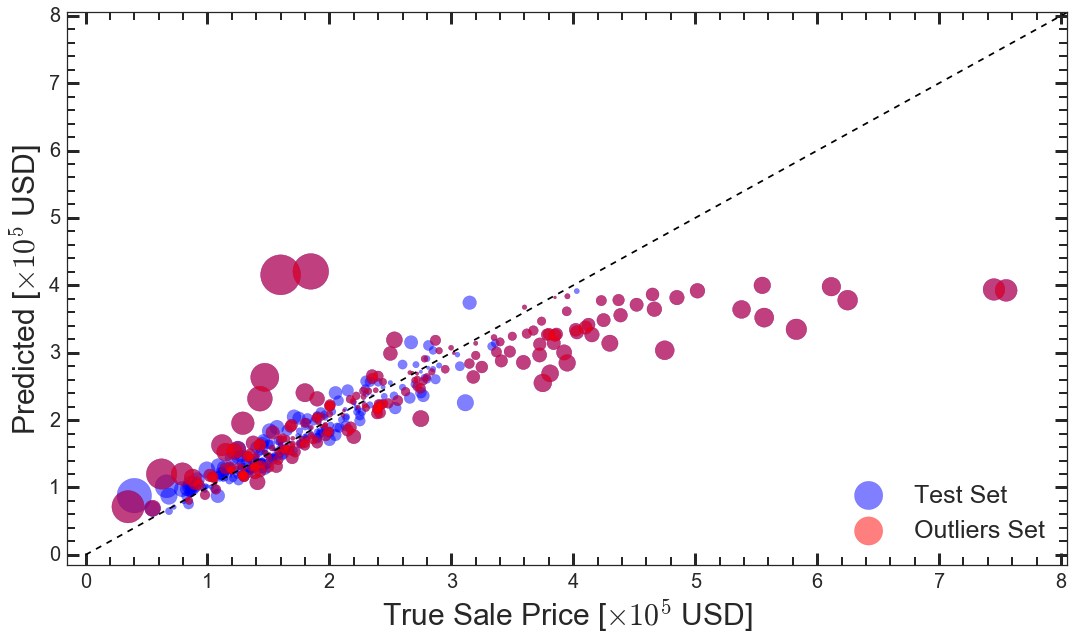

In [151]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
plt.scatter(y_test_data_out_good/1e5, pred_out_good/1e5, alpha = 0.5, 
            s = 1000*np.abs(y_test_data_out_good-pred_out_good)/y_test_data_out_good, color = 'blue',
           label ='Test Set')
plt.scatter(y_out/1e5, pred_out/1e5, alpha = 0.5, s = 1000*np.abs(y_out-pred_out)/y_out, color = 'red',
           label ='Outliers Set')
plt.xlabel(r"True Sale Price [$\times 10^{5} $ USD]", fontsize = 30);
plt.ylabel(r"Predicted [$\times 10^{5} $ USD]", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.plot(np.arange(0,10, 1), np.arange(0,10, 1), 'k--')
plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.xlim(min([min(y_out), min(pred_out)])/1e5-0.5, max([max(y_out), max(pred_out)])/1e5+0.5)
plt.ylim(min([min(y_out), min(pred_out)])/1e5-0.5, max([max(y_out), max(pred_out)])/1e5+0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc = 'lower right', fontsize=25)
#plt.savefig("FinalModel_linear_out.pdf")

In [152]:
print 'Kaggle\'s log-RMSE score is {:.6f}'.\
format(np.sqrt(np.sum((np.log(y_test_data_out_good +1) - np.log(pred_out_good+1))**2)/len(y_test_data_out_good)))

Kaggle's log-RMSE score is 0.157974


In [ ]:
diff_out = (y_test_data_out_good - pred_out_good)/y_test_data_out_good*100.
sns.distplot(diff_good, bins=20, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
                                                    "alpha": 0.60, "color": "pink"});
plt.xlabel(r"$\frac{y_{test} - \mathrm{pred} }{y_{test}}$" + r"[$ \times $ 100%]", fontsize = 30);
plt.ylabel(r"Frequency", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
#plt.savefig('FinalDiffDist_linear_out.pdf')

print "The mean is {:.2f} and stdev of {:.2f}".format(np.mean(diff_out), np.std(diff_out))
diff_out = diff_out.reset_index(drop=True)
X_test_data_out_good.iloc[np.argmin(diff_out),:]

## Now testing on the test.csv set.

In [30]:
# Then load test.csv
test = pd.read_csv('test.csv')
test['Age'] = test.YrSold - test.YearBuilt
test['RemodAge'] = test.YrSold - test.YearRemodAdd
test = test.drop(['Id', 'YrSold', 'YearBuilt', 'YearRemodAdd'], axis=1)
test['MSSubClass'] = test['MSSubClass'].astype(int).astype('str')
# Success
print "Ames housing dataset has {} data points with {} variables each.".format(*test.shape)
print test.head(3)

Ames housing dataset has 1459 data points with 78 variables each.
  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour  \
0         20       RH         80.0    11622   Pave   NaN      Reg         Lvl   
1         20       RL         81.0    14267   Pave   NaN      IR1         Lvl   
2         60       RL         74.0    13830   Pave   NaN      IR1         Lvl   

  Utilities LotConfig   ...    PoolArea PoolQC  Fence MiscFeature MiscVal  \
0    AllPub    Inside   ...           0    NaN  MnPrv         NaN       0   
1    AllPub    Corner   ...           0    NaN    NaN        Gar2   12500   
2    AllPub    Inside   ...           0    NaN  MnPrv         NaN       0   

  MoSold  SaleType  SaleCondition Age RemodAge  
0      6        WD         Normal  49       49  
1      6        WD         Normal  52       52  
2      3        WD         Normal  13       12  

[3 rows x 78 columns]


In [31]:
test = remove_nans(test)
test_X = preprocess_features(test)
print "Processed feature columns ({} total features):\n{}".format(len(test_X.columns), list(sorted(test_X.columns)))

MSZoning 4
LotFrontage 227
Alley 1352
Utilities 2
Exterior1st 1
Exterior2nd 1
MasVnrType 16
MasVnrArea 15
BsmtQual 44
BsmtCond 45
BsmtExposure 44
BsmtFinType1 42
BsmtFinSF1 1
BsmtFinType2 42
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
KitchenQual 1
Functional 2
FireplaceQu 730
GarageType 76
GarageYrBlt 78
GarageFinish 78
GarageCars 1
GarageArea 1
GarageQual 78
GarageCond 78
PoolQC 1456
Fence 1169
MiscFeature 1408
SaleType 1
(1459, 78)
Processed feature columns (244 total features):
['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Age', 'Alley_0.0', 'Alley_Grvl', 'Alley_Pave', 'BedroomAbvGr', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'BsmtCond', 'BsmtExposure_0.0', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1_0.0', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_0.0'

## Make the test set features compatible with the training set.

In [38]:
## Fix the test set.
add_to_test_cols = list(set(X_all.columns) - set(test_X.columns) )
## Append these as zeroes to the testing set.
for col in add_to_test_cols:
    if col not in test_X.columns:
        test_X.insert(len(test_X.columns), col, 0 )
print test_X.columns

Index([u'MSSubClass_120', u'MSSubClass_150', u'MSSubClass_160',
       u'MSSubClass_180', u'MSSubClass_190', u'MSSubClass_20',
       u'MSSubClass_30', u'MSSubClass_40', u'MSSubClass_45', u'MSSubClass_50',
       ...
       u'Exterior1st_Stone', u'RoofMatl_ClyTile', u'Condition2_RRAe',
       u'RoofMatl_Roll', u'Condition2_RRNn', u'RoofMatl_Membran',
       u'Condition2_RRAn', u'RoofMatl_Metal', u'Electrical_Mix',
       u'Exterior1st_ImStucc'],
      dtype='object', length=259)


In [41]:
test_X_all = test_X[X_all.columns]  
print list(set(test_X_all.columns) - set(X_all.columns))
print list(set(X_all.columns) - set(test_X_all.columns))
print "Now train.csv has the same columns as test.csv"

[]
[]
Now train.csv has the same columns as test.csv


The mean is 176855.70 and stdev of 70223.33


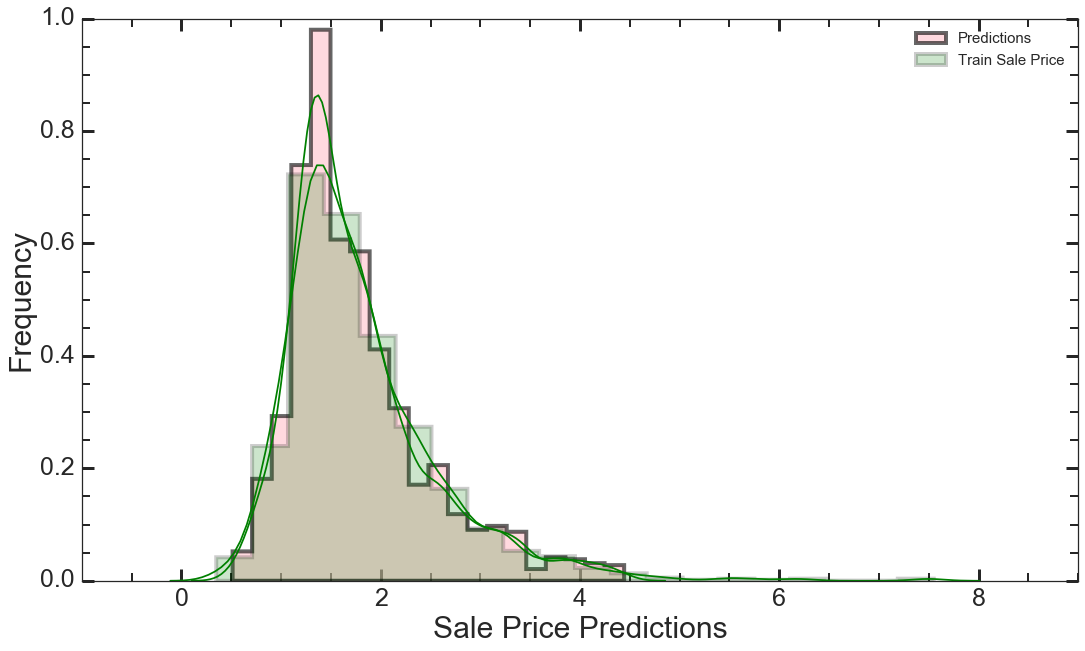

In [62]:
pred_test = reg2.predict(test_X_all)
sns.distplot(pred_test/1e5, bins=20, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
                                                    "alpha": 0.60, "color": "pink"}, label = 'Predictions');
sns.distplot(data['SalePrice']/1e5, bins=20, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
                                                    "alpha": 0.20, "color": "green"}, label = 'Train Sale Price');
#sns.distplot(pred2/1e5, bins=20, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
#                                                    "alpha": 0.10, "color": "blue"});


plt.xlabel(r"Sale Price Predictions", fontsize = 30);
plt.ylabel(r"Frequency", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
#plt.savefig('FinalDiffDist_linear_out.pdf')

print "The mean is {:.2f} and stdev of {:.2f}".format(np.mean(pred_test), np.std(pred_test))
plt.legend()

In [122]:
Ames_Submission = pd.DataFrame(np.transpose([test.Id, pred_test ]), columns=['Id', 'SalePrice'])
#Ames_Submission = Ames_Submission.set_index('Id')
Ames_Submission['Id'] = Ames_Submission.Id.astype('int')
Ames_Submission.to_csv('Ames_Submission.csv', sep=',',  index=False)
Ames_Submission.dtypes
#a = np.asarray(np.transpose(), dtype=dt)
#np.savetxt('', a )

Id             int64
SalePrice    float64
dtype: object

In [68]:
test = pd.read_csv('test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [124]:
tmp=pd.read_csv('Ames_Submission.csv')
tmp.head()

,Id,SalePrice
0,1461,124328.437447
1,1462,160178.336717
2,1463,182218.314573
3,1464,187708.786879
4,1465,197538.714542
